# Regression Model to Back Fill 2001 - 2008 Electric Accounts for Per Capita Electricity Sales Calculation

**Sectors**
* RES - US Census
* COM and IND - SUSB Employment Count

In [ ]:
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
try:
    from google.colab import drive

    drive.mount('./drive/')

    %cd /content/drive/Shareddrives/Data606_Energy

except:
    print("No Colab Environment")

Mounted at ./drive/
/content/drive/Shareddrives/Data606_Energy


In [ ]:
import sys
import pandas as pd
import glob
from tqdm.autonotebook import tqdm
sys.path.append("helpers/")

from energygrid import EGRID

from helper_functions import write_csv, combine_like_files
import json
import numpy as np

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


# Get the Census Data

In [ ]:
df_pop_all = pd.read_csv('/content/drive/Shareddrives/Data606_Energy/data/percapita/us_census/us_census_2000_2020.csv')
df_pop_all['NAME'] = df_pop_all['abbrv']
df_pop_all = df_pop_all.set_index(['NAME','year'])

# Get the SUSB Data

In [ ]:
df_susb = pd.read_csv('/content/drive/Shareddrives/Data606_Energy/data/fill_ready/SUSB_data_all_2001_2018.csv',index_col=None)

In [ ]:
df_susb.head()

,STATE,DESCRIPTION,YEAR,Employment,Establishments,Firms,NAICS_Description_lower,Classification
0,AL,Accommodation & foodservices,2001,127776.0,6870.0,4697.0,accommodation & foodservices,COM
1,AL,Accommodation & foodservices,2002,128964.0,7070.0,4801.0,accommodation & foodservices,COM
2,AL,Accommodation and Food Services,2003,139440.0,7178.0,4918.0,accommodation and food services,COM
3,AL,Accommodation and Food Services,2004,141442.0,7292.0,5089.0,accommodation and food services,COM
4,AL,Accommodation and Food Services,2005,145447.0,7529.0,5256.0,accommodation and food services,COM


In [ ]:
df_susb[['Employment','Establishments','Firms']].corr()

,Employment,Establishments,Firms
Employment,1.000000,0.986306,0.980288
Establishments,0.986306,1.000000,0.998053
Firms,0.980288,0.998053,1.000000


All three of these variables are highly correlated so I shouldn't be using more than one of them as inputs. I will use trial and error to find out which one works best.

After doing trial and error I found that using Establishments gives the best R-squared for the COM accounts predictions, but Employment gives the best R-squared for the IND accounts predictions. Since the IND accounts predictions is the one struggling the most, I am choosing to use Employment as the predictor.

# Get the Electric Accounts Data

In [ ]:
with open ("creds/eia_creds.json") as f:
    creds = json.load(f)
    key = creds.get("key")

In [ ]:
df = combine_like_files("data/percapita/electric_accounts/json/*/*",pd.read_json)

In [ ]:
df.head()

,series_id,name,units,f,description,copyright,source,iso3166,geography,start,end,updated,data,sector
0,ELEC.CUSTOMERS.DC-RES.M,Number of customer accounts : District Of Colu...,number of customers,M,Electricity sold to residential customers; Ele...,None,"EIA, U.S. Energy Information Administration",USA-DC,USA-DC,200801,202107,2021-09-23T14:54:35-0400,"[202107, 298534]",RES
1,ELEC.CUSTOMERS.DC-RES.M,Number of customer accounts : District Of Colu...,number of customers,M,Electricity sold to residential customers; Ele...,None,"EIA, U.S. Energy Information Administration",USA-DC,USA-DC,200801,202107,2021-09-23T14:54:35-0400,"[202106, 298233]",RES
2,ELEC.CUSTOMERS.DC-RES.M,Number of customer accounts : District Of Colu...,number of customers,M,Electricity sold to residential customers; Ele...,None,"EIA, U.S. Energy Information Administration",USA-DC,USA-DC,200801,202107,2021-09-23T14:54:35-0400,"[202105, 297799]",RES
3,ELEC.CUSTOMERS.DC-RES.M,Number of customer accounts : District Of Colu...,number of customers,M,Electricity sold to residential customers; Ele...,None,"EIA, U.S. Energy Information Administration",USA-DC,USA-DC,200801,202107,2021-09-23T14:54:35-0400,"[202104, 297518]",RES
4,ELEC.CUSTOMERS.DC-RES.M,Number of customer accounts : District Of Colu...,number of customers,M,Electricity sold to residential customers; Ele...,None,"EIA, U.S. Energy Information Administration",USA-DC,USA-DC,200801,202107,2021-09-23T14:54:35-0400,"[202103, 296649]",RES


In [ ]:
df['Date'] = [d[0] for d in df['data']]
df['Accounts'] = [d[1] for d in df['data']]
df['Date'] = pd.to_datetime(df['Date'],format='%Y%m')
df['State'] = df['geography'].str[-2:]

In [ ]:
required_data = df[['sector','Date','Accounts','State']]

In [ ]:
required_data = required_data.set_index(['State','Date'])

# Now I have both sets of data - I will start the linear regression

In [ ]:
# I will perform the linear regression on each state and sector so I need a list of all the states and sectors
states = np.unique(np.array([ind[0] for ind in required_data.index]))
sectors = list(required_data['sector'].unique())
sectors.remove('ALL')
sectors.remove('TRA')

In [ ]:
# this function will interpolate the census data to a monthly level - currently isn't implemented but I'm keeping in case we revert using monthly
def interpolate_census(census):
  # drop the state index - it's already subsetted on state so this will make things easier to drop it
  census = census.reset_index(level=0,drop=True)
  census['year'] = census.index
  # make it so that each years census estimate is for december
  census['Date'] = census['year'].astype(str)+'-12'
  census['new_year'] = pd.to_datetime(census['Date'], format='%Y-%m')
  census = census.set_index(census['new_year'])
  # make the population variable numeric so it will get interpolated
  census['state_population'] = pd.to_numeric(census['state_population'])
  census_resampled = census.resample('MS').interpolate()
  census_resampled.index.freq=None
  return census_resampled[['state_population']]

In [ ]:
# the dates that need to be predicted

# this below is used for predicting at an annual level
#dates_to_predict = [datetime(year=2000,month=12,day=1)]
dates_to_predict = [2000]
for year in range(2001,2021):
  #dates_to_predict.append(datetime(year=year,month=12,day=1))
  dates_to_predict.append(year)

#### Loop through each state and sector and perform linear regression using the census state population, a constant term, and the year as the predictors. The mean electric accounts by year for each sector is used as the target variable.

In [ ]:
# the below code is for building models on annual data
models = {}
results_sectors = []
results_states = []
results_r2 = []
predictions = pd.DataFrame(index=dates_to_predict)
for state in states:
  models[state] = {}
  # gather the population data and interpolate it
  #census = df_population_recordwise[df_population_recordwise['abbrv']==state]
  census = df_pop_all[df_pop_all['abbrv']==state]
  #census_resampled = interpolate_census(census)
  census['constant'] = [1]*census.shape[0]
  census['year'] = census.index.get_level_values(1)
  census = census.dropna()
  susb_state = df_susb[df_susb['STATE']==state].copy()
  # gather the sector electric accounts data
  for sector in sectors:
    sector_accounts = required_data[required_data['sector']==sector].copy()
    sector_accounts = sector_accounts.reset_index(level=0,drop=False)
    sector_accounts_state = sector_accounts[sector_accounts['State']==state]
    # drop any n/a values
    sector_accounts_state = sector_accounts_state.dropna()
    # now group by year
    sector_accounts_state = sector_accounts_state.groupby(by=sector_accounts_state.index.year).mean()
    # find the dates in common between the two datasets
    census_for_reg = census.copy()
    census_for_reg.index = census_for_reg.index.get_level_values(1)
    common_dates = list(set(list(census_for_reg.index))&set(list(sector_accounts_state.index)))
    census_for_reg = census_for_reg.loc[sorted(common_dates)]
    sector_accounts_for_reg = sector_accounts_state.loc[sorted(common_dates)]
    # run the regression
    census_for_reg['year'] = census_for_reg.index
    # subset the susb on the sector if neccessary
    if sector in ['IND','COM']:
      susb_state_sector = susb_state[susb_state['Classification']==sector].copy()
      susb_grouped = susb_state_sector.groupby(by='YEAR').sum()
      census_for_reg['Employment'] = susb_grouped['Employment']
      census_for_reg = census_for_reg.dropna()
      census_for_reg = census_for_reg[census_for_reg['year']<2017]
      mod = sm.OLS(sector_accounts_for_reg.loc[census_for_reg.index]['Accounts'], census_for_reg[['Employment','state_population','year','constant']])
    else:
      mod = sm.OLS(sector_accounts_for_reg['Accounts'], census_for_reg[['state_population','year','constant']])
    res = mod.fit()
    models[state][sector] = res
    results_sectors.append(sector)
    results_states.append(state)
    results_r2.append(res.rsquared)
    for_pred = census[census.index.get_level_values(1)<2021][['state_population','year','constant']]
    for_pred.index = for_pred.index.get_level_values(1)
    if sector in ['IND','COM']:
      for_pred['Employment'] = susb_grouped['Employment']
      for_pred = for_pred.dropna()
      for_pred = for_pred[for_pred['year']<2017]
      predictions[sector+'_'+state] = np.nan
      predictions[sector+'_'+state].loc[for_pred.index] = res.predict(np.array(for_pred[['Employment','state_population','year','constant']]))
    else:
      for_pred = for_pred.dropna()
      predictions[sector+'_'+state] = np.nan
      predictions[sector+'_'+state].loc[for_pred.index] = res.predict(np.array(for_pred[['state_population','year','constant']]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [ ]:
census_for_reg.head(50)

,abbrv,state_population,constant,year,Employment
year,,,,,
2008,WY,546043.0,1,2008,71728.0
2009,WY,559851.0,1,2009,70075.0
2010,WY,564531.0,1,2010,66225.0
2011,WY,567491.0,1,2011,66408.0
2012,WY,576656.0,1,2012,68621.0
2013,WY,582620.0,1,2013,69620.0
2014,WY,583159.0,1,2014,71669.0
2015,WY,586389.0,1,2015,71628.0
2016,WY,585243.0,1,2016,69420.0


#### A view of the predictions

In [ ]:
predictions.head(21)

,RES_AK,IND_AK,COM_AK,RES_AL,IND_AL,COM_AL,RES_AR,IND_AR,COM_AR,RES_AZ,IND_AZ,COM_AZ,RES_CA,IND_CA,COM_CA,RES_CO,IND_CO,COM_CO,RES_CT,IND_CT,COM_CT,RES_DC,IND_DC,COM_DC,RES_DE,IND_DE,COM_DE,RES_FL,IND_FL,COM_FL,RES_GA,IND_GA,COM_GA,RES_HI,IND_HI,COM_HI,RES_IA,IND_IA,COM_IA,RES_ID,...,COM_OR,RES_PA,IND_PA,COM_PA,RES_RI,IND_RI,COM_RI,RES_SC,IND_SC,COM_SC,RES_SD,IND_SD,COM_SD,RES_TN,IND_TN,COM_TN,RES_TX,IND_TX,COM_TX,RES_UT,IND_UT,COM_UT,RES_VA,IND_VA,COM_VA,RES_VT,IND_VT,COM_VT,RES_WA,IND_WA,COM_WA,RES_WI,IND_WI,COM_WI,RES_WV,IND_WV,COM_WV,RES_WY,IND_WY,COM_WY
2000,252927.470633,NaN,NaN,2.080504e+06,NaN,NaN,1.290709e+06,NaN,NaN,2.105690e+06,NaN,NaN,1.229973e+07,NaN,NaN,1.896467e+06,NaN,NaN,1.474134e+06,NaN,NaN,115130.022823,NaN,NaN,276511.228506,NaN,NaN,7.490441e+06,NaN,NaN,2.807995e+06,NaN,NaN,388690.891744,NaN,NaN,1.246620e+06,NaN,NaN,543548.678315,...,NaN,5.219340e+06,NaN,NaN,421644.444314,NaN,NaN,1.798255e+06,NaN,NaN,323909.812872,NaN,NaN,2.158044e+06,NaN,NaN,7.825935e+06,NaN,NaN,7.430313e+05,NaN,NaN,3.056510e+06,NaN,NaN,299868.782507,NaN,NaN,2.596870e+06,NaN,NaN,2.727666e+06,NaN,NaN,869070.672841,NaN,NaN,235584.518054,NaN,NaN
2001,254880.106014,1658.331045,42999.642874,2.094141e+06,11814.117827,406435.259846,1.299238e+06,28119.099926,168984.224207,2.145276e+06,7100.758100,272816.799318,1.234981e+07,83851.864021,1.834209e+06,1.916897e+06,3653.688926,359152.275848,1.469182e+06,6054.673238,147179.420064,126754.618017,1.0,34693.010147,283101.152510,-3000.430830,46723.639124,7.611220e+06,21834.647044,1.097982e+06,2.935418e+06,18599.399914,481479.797558,391305.736568,655.035163,61946.819116,1.266716e+06,5814.950706,177726.293952,552252.895951,...,237438.387595,5.236653e+06,32796.242886,656058.902861,428261.525529,2259.638717,53004.958676,1.802876e+06,5923.047522,294178.533931,330331.630479,1705.500220,63575.320499,2.168455e+06,-1270.716885,442020.815123,8.048375e+06,246634.306369,1.514976e+06,7.563848e+05,9508.260308,88777.044375,3.071776e+06,8634.208855,389651.993224,300573.888546,512.438472,50731.201623,2.614273e+06,23446.033557,334335.703461,2.710979e+06,5521.863846,329855.925198,868379.203617,11101.651191,131098.241151,237584.150685,7170.716183,62642.494317
2002,256791.685075,1451.650299,43538.553277,2.109349e+06,10273.346080,407934.998819,1.307045e+06,28521.911386,170782.208720,2.189578e+06,6800.204269,275752.495394,1.241192e+07,70669.729342,1.824730e+06,1.941625e+06,5492.882466,353423.346145,1.461632e+06,5886.510261,149119.683422,140646.539616,1.0,33544.098681,292711.887418,-2518.392402,47130.151600,7.745838e+06,21185.174099,1.090179e+06,3.029385e+06,17828.872993,485344.496096,393922.767398,670.424243,61752.330605,1.287718e+06,5388.136762,197608.623790,560891.647390,...,239057.950946,5.244229e+06,33139.141989,657694.680624,436569.659296,2280.148388,53084.041499,1.810026e+06,5828.860620,292019.885572,336789.612429,1903.717289,63474.180059,2.174062e+06,-1511.176692,443132.873335,8.274835e+06,198493.963627,1.447476e+06,7.706871e+05,9545.457571,87501.657384,3.088670e+06,8920.815629,393824.033872,301229.072777,426.438247,49936.832410,2.625875e+06,24441.127898,335537.068715,2.684580e+06,5152.398516,330540.769789,868001.102503,11188.614485,131821.996984,239702.667461,7421.912294,62402.165686
2003,258739.660163,1338.922295,44140.420263,2.118835e+06,9932.209832,405972.635919,1.312472e+06,29097.005818,172246.699462,2.229746e+06,6863.275775,278974.480816,1.247537e+07,90251.047781,1.796296e+06,1.969685e+06,9124.025319,348751.425731,1.454257e+06,5726.875719,151685.062096,156511.345125,1.0,31978.930422,305924.358405,-2051.652107,47365.749646,7.869790e+06,21583.056265,1.095652e+06,3.093212e+06,18432.160094,488360.493068,396536.041695,680.790872,61807.052537,1.301492e+06,5234.457057,208961.374677,570924.506871,...,237515.679211,5.245281e+06,32521.382732,660097.020969,441881.921288,2278.904440,53206.820477,1.816805e+06,5828.950959,290583.677786,342496.732209,2131.753924,63830.008004,2.196416e+06,-1571.718408,444435.379899,8.528665e+06,15910

In [ ]:
predictions['year'] = predictions.index
predictions.to_csv('data/fill_ready/electric_accounts_fillin_values.csv')

## Gather predictions for 2021 census data

In [ ]:
census_2021_predictions = pd.DataFrame(index=[datetime(year=2021,month=12,day=1)])
for state in states:
  # gather the sector electric accounts data
  state_sectors = [k for k in models[state]]
  r_2_for_state = np.array([models[state][k].rsquared for k in models[state]])
  #best_estimate_sector = state_sectors[np.argmax(r_2_for_state)]
  best_estimate_sector = 'RES'

  sector_accounts = required_data[required_data['sector']==best_estimate_sector].copy()
  sector_accounts = sector_accounts.reset_index(level=0,drop=False)
  sector_accounts_state = sector_accounts[sector_accounts['State']==state]
  accounts_2021_12_1 = sector_accounts_state.loc[datetime(year=2021,month=7,day=1)]
  b1 = models[state][best_estimate_sector].params['state_population']
  b2 = models[state][best_estimate_sector].params['year']
  c = models[state][best_estimate_sector].params['constant']
  # infer the value from the accounts - use accounts = b1*state_population + b2*year + c
  # so state_population = (accounts-c-b2*year)/b1
  census_2021 = (accounts_2021_12_1['Accounts']-c-b2*2021)/b1
  census_2021_predictions[str(state)] = census_2021

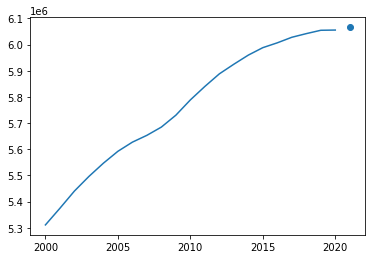

In [ ]:
# check out one sample
sample_state='MD'
plt.plot(list(df_pop_all[(df_pop_all['abbrv']==sample_state)]['state_population'].index.get_level_values(1)),list(df_pop_all[(df_pop_all['abbrv']==sample_state)]['state_population']))
plt.scatter(2021,census_2021_predictions[sample_state])

### Write the predictions to a csv

In [ ]:
census_2021_predictions.to_csv('data/fill_ready/census_2021_fillin_values.csv')

## Now make sure results look reasonalbe

In [ ]:
model_results = pd.DataFrame({'State':results_states,'Sector':results_sectors,'R-Squared':results_r2})

In [ ]:
model_results = model_results[model_results['State']!='DC']

In [ ]:
model_results[model_results['Sector']=='RES'].copy().groupby('State').mean().sort_values(by='R-Squared',ascending=False)

,R-Squared
State,
HI,0.998665
AZ,0.997959
ID,0.997526
SD,0.994511
MD,0.993800
NY,0.993761
MT,0.993201
AK,0.992867
FL,0.991809


In [ ]:
model_results.copy().groupby('Sector').mean().sort_values(by='R-Squared',ascending=False)

,R-Squared
Sector,
RES,0.942734
COM,0.878632
IND,0.787149


## First, pick a state and make sure the predicted values look reasonable

In [ ]:
RES_accounts = required_data[(required_data['sector']=='RES')]
RES_accounts = RES_accounts.reset_index(level=0,drop=False)
RES_accounts['year'] = RES_accounts.index.year
COM_accounts = required_data[(required_data['sector']=='COM')]
COM_accounts = COM_accounts.reset_index(level=0,drop=False)
COM_accounts['year'] = COM_accounts.index.year
IND_accounts = required_data[(required_data['sector']=='IND')]
IND_accounts = IND_accounts.reset_index(level=0,drop=False)
IND_accounts['year'] = IND_accounts.index.year

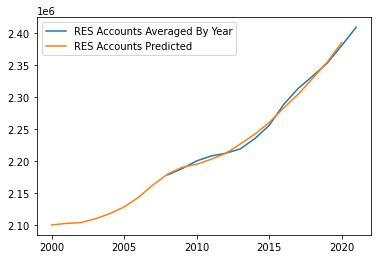

In [ ]:
sample_state = 'MD'
plt.plot(RES_accounts[RES_accounts['State']==sample_state].groupby(by='year').mean()['Accounts'], label='RES Accounts Averaged By Year')
plt.plot(predictions['year'],predictions['RES_'+sample_state], label='RES Accounts Predicted')
plt.legend()

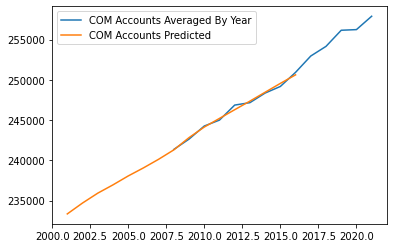

In [ ]:
plt.plot(COM_accounts[COM_accounts['State']==sample_state].groupby(by='year').mean()['Accounts'], label='COM Accounts Averaged By Year')
plt.plot(predictions.index,predictions['COM_'+sample_state], label='COM Accounts Predicted')
plt.legend()

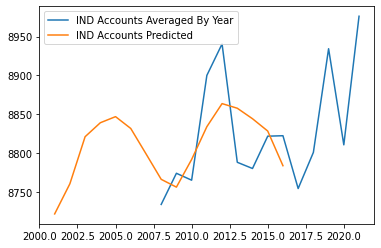

In [ ]:
plt.plot(IND_accounts[IND_accounts['State']==sample_state].groupby(by='year').mean()['Accounts'], label='IND Accounts Averaged By Year')
plt.plot(predictions.index,predictions['IND_'+sample_state], label='IND Accounts Predicted')
plt.legend()

# Next, when looking at the R-Squared values by state, there were some very poor performers. Let's explore why using WV as an example

#### Plot of WV Census Population

In [ ]:
sample_state = 'WV'

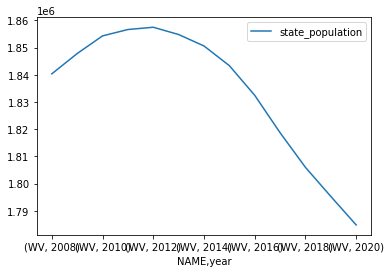

In [ ]:
df_pop_all[(df_pop_all['abbrv']==sample_state)&(df_pop_all.index.get_level_values(1)>=2008)].plot()

#### Plots of the different Electric Accounts

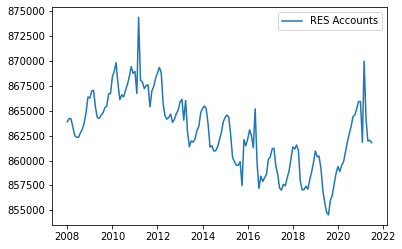

In [ ]:
RES_accounts = required_data[(required_data['sector']=='RES')]
RES_accounts = RES_accounts.reset_index(level=0,drop=False)
COM_accounts = required_data[(required_data['sector']=='COM')]
COM_accounts = COM_accounts.reset_index(level=0,drop=False)
IND_accounts = required_data[(required_data['sector']=='IND')]
IND_accounts = IND_accounts.reset_index(level=0,drop=False)

plt.plot(RES_accounts[RES_accounts['State']==sample_state]['Accounts'], label='RES Accounts')
plt.legend()

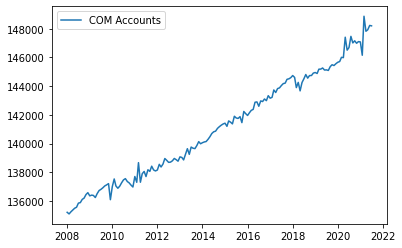

In [ ]:
plt.plot(COM_accounts[COM_accounts['State']==sample_state]['Accounts'], label='COM Accounts')
plt.legend()

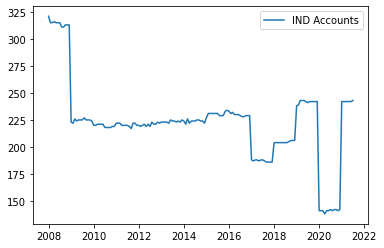

In [ ]:
plt.plot(IND_accounts[IND_accounts['State']=='VT']['Accounts'], label='IND Accounts')
plt.legend()

### Now to see how the predictions look for this state

Census population plot

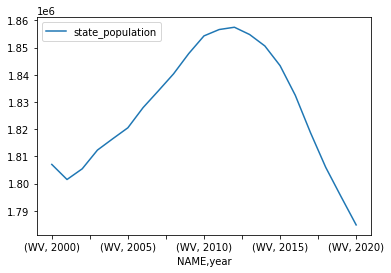

In [ ]:
df_pop_all[(df_pop_all['abbrv']==sample_state)].plot()

Electric Accounts

In [ ]:
RES_accounts['year'] = RES_accounts.index.year

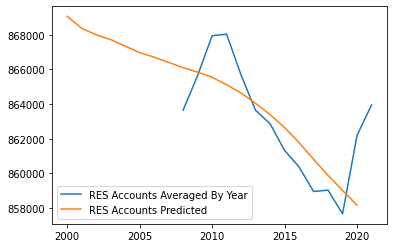

In [ ]:
sample_state = 'WV'
plt.plot(RES_accounts[RES_accounts['State']==sample_state].groupby(by=RES_accounts[RES_accounts['State']==sample_state].index.year).mean()['Accounts'], label='RES Accounts Averaged By Year')
plt.plot(predictions.index,predictions['RES_'+sample_state], label='RES Accounts Predicted')
plt.legend()

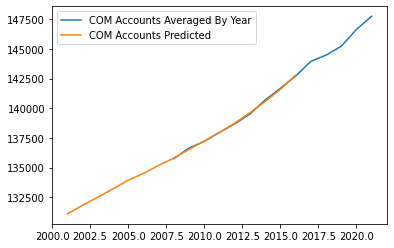

In [ ]:
plt.plot(COM_accounts[COM_accounts['State']==sample_state].groupby(by=COM_accounts[COM_accounts['State']==sample_state].index.year).mean()['Accounts'], label='COM Accounts Averaged By Year')
plt.plot(predictions.index,predictions['COM_'+sample_state], label='COM Accounts Predicted')
plt.legend()

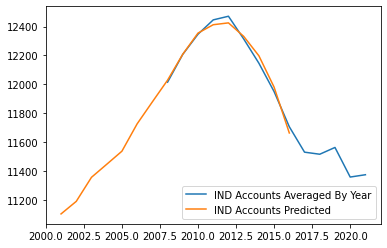

In [ ]:
plt.plot(IND_accounts[IND_accounts['State']==sample_state].groupby(by=IND_accounts[IND_accounts['State']==sample_state].index.year).mean()['Accounts'], label='IND Accounts Averaged By Year')
plt.plot(predictions.index,predictions['IND_'+sample_state], label='IND Accounts Predicted')
plt.legend()